### Loading and preparing the data

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Yoga-82/new_processed_data.csv')

In [ ]:
# Get percentage distribution per class
class_percentages = df['pose_name'].value_counts(normalize=True) * 100
# Define thresholds (you can adjust these)
min_threshold = 0.5   # remove classes < 0.5%
max_threshold = 3.5   # remove classes > 3.5%

# Find classes to remove
classes_to_remove = class_percentages[(class_percentages < min_threshold) |
                                      (class_percentages > max_threshold)].index.tolist()
# Define thresholds (you can adjust these)
min_threshold = 0.5   # remove classes < 0.5%
max_threshold = 3.5   # remove classes > 3.5%

# Find classes to remove
classes_to_remove = class_percentages[(class_percentages < min_threshold) |
                                      (class_percentages > max_threshold)].index.tolist()
# Remove rows with unwanted classes
filtered_df = df[~df['pose_name'].isin(classes_to_remove)]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df.shape

(14288, 2)

In [ ]:
X = filtered_df['landmarks']
y = filtered_df['pose_name']

###Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_unprocessed = X_train.copy()
X_test_unprocessed = X_test.copy()

In [ ]:
X_train_unprocessed[0]

'[ 0.30616775  0.25739732  0.00568089  0.2931737   0.23219228  0.02864379\n  0.2910392   0.23184526  0.02853676  0.28837207  0.2316906   0.02836072\n  0.28853926  0.23267941 -0.04427852  0.28293598  0.23300958 -0.04438914\n  0.27713102  0.23380141 -0.04451643  0.25715107  0.25258142  0.15470687\n  0.24847387  0.25466374 -0.17498942  0.30018783  0.29147732  0.05981233\n  0.2944563   0.29455274 -0.03629289  0.28066823  0.41389337  0.35909149\n  0.23080494  0.42253399 -0.33576414  0.4450219   0.44364572  0.48594213\n  0.40935254  0.45546189 -0.41750458  0.58066154  0.43048531  0.38751999\n  0.5714938   0.43223101 -0.31811073  0.62471128  0.43124771  0.40158337\n  0.61754763  0.43930656 -0.36835647  0.62298596  0.41302514  0.34051725\n  0.62226367  0.41203508 -0.34198028  0.60278815  0.41397938  0.35676241\n  0.60036266  0.40975684 -0.30543834  0.40458995  0.74163425  0.22242691\n  0.37725437  0.7710163  -0.22235501  0.52224165  0.45858732  0.25002709\n  0.52031344  0.45353356 -0.20166303 

In [ ]:
import numpy as np

def preprocess_first(X: pd.Series) -> np.ndarray:
    """
    Converts a pandas Series of stringified arrays into a NumPy array.
    Each element in the Series is expected to be a string like "[1.0 2.0 3.0]".
    """
    return np.vstack(X.apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))).astype(np.float64)


In [ ]:
from sklearn.preprocessing import FunctionTransformer

preprocess_first = FunctionTransformer(preprocess_first)

In [ ]:
X_train = preprocess_first.fit_transform(X_train)
X_test = preprocess_first.transform(X_test)

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

class_percentages = y_train.value_counts(normalize=True) * 100

rare_classes = class_percentages[class_percentages < 1].index.tolist()
sampling_strategy = {cls: int(y_train.value_counts().max()) for cls in rare_classes}
sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_reshaped = np.vstack(X_train).reshape(X_train.shape[0], -1)
X_resampled, y_resampled = sm.fit_resample(X_train_reshaped, y_train)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = X_resampled.reshape(X_resampled.shape[0], -1)
X_train = scaler.fit_transform(X_train)
X_test_reshaped = np.vstack(X_test).reshape(X_test.shape[0], -1)
X_test = scaler.transform(X_test_reshaped)

In [ ]:
import numpy as np

def select_relevant_landmarks(X: np.ndarray, relevant_ids=None) -> np.ndarray:
    if relevant_ids is None:
        relevant_ids = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28, 31, 32]

    selected_indices = []
    for idx in relevant_ids:
        selected_indices.extend([idx * 3, idx * 3 + 1, idx * 3 + 2])

    return X[:, selected_indices]

In [ ]:
preprocess_second = FunctionTransformer(select_relevant_landmarks)

In [ ]:
X_train = preprocess_second.fit_transform(X_train)
X_test = preprocess_second.transform(X_test)

In [ ]:
y_train = y_resampled

###Training and Evaluation

In [ ]:
pip install tensorflow


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Label encode
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ELU
import keras
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    ELU(),
    Dropout(0.3),

    Dense(128),
    BatchNormalization(),
    ELU(),
    Dropout(0.2),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

In [ ]:
history = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint, earlystopping]
)


Epoch 1/200
512/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2724 - loss: 3.0358
Epoch 1: val_accuracy improved from -inf to 0.59972, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2747 - loss: 3.0246 - val_accuracy: 0.5997 - val_loss: 1.6295
Epoch 2/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6125 - loss: 1.4970
Epoch 2: val_accuracy improved from 0.59972 to 0.71728, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6128 - loss: 1.4960 - val_accuracy: 0.7173 - val_loss: 1.1690
Epoch 3/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6892 - loss: 1.1746
Epoch 3: val_accuracy improved from 0.71728 to 0.75717, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6892 - loss: 1.1746 - val_accuracy: 0.7572 - val_loss: 0.9994
Epoch 4/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7242 - loss: 1.0242
Epoch 4: val_accuracy improved from 0.75717 to 0.76767, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7242 - loss: 1.0239 - val_accuracy: 0.7677 - val_loss: 0.9249
Epoch 5/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7522 - loss: 0.9327
Epoch 5: val_accuracy improved from 0.76767 to 0.79146, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7523 - loss: 0.9327 - val_accuracy: 0.7915 - val_loss: 0.8929
Epoch 6/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7620 - loss: 0.8673
Epoch 6: val_accuracy did not improve from 0.79146
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7620 - loss: 0.8673 - val_accuracy: 0.7845 - val_loss: 0.8561
Epoch 7/200
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7789 - loss: 0.8174
Epoch 7: val_accuracy improved from 0.79146 to 0.79776, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7789 - loss: 0.8175 - val_accuracy: 0.7978 - val_loss: 0.8277
Epoch 8/200
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7777 - loss: 0.8000
Epoch 8: val_accuracy improved from 0.79776 to 0.80616, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7777 - loss: 0.8000 - val_accuracy: 0.8062 - val_loss: 0.7911
Epoch 9/200
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7833 - loss: 0.7792
Epoch 9: val_accuracy did not improve from 0.80616
520/520 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7833 - loss: 0.7792 - val_accuracy: 0.8044 - val_loss: 0.7907
Epoch 10/200
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7935 - loss: 0.7573
Epoch 10: val_accuracy improved from 0.80616 to 0.81386, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7935 - loss: 0.7574 - val_accuracy: 0.8139 - val_loss: 0.7777
Epoch 11/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7990 - loss: 0.7389
Epoch 11: val_accuracy improved from 0.81386 to 0.81910, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7990 - loss: 0.7389 - val_accuracy: 0.8191 - val_loss: 0.7695
Epoch 12/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8049 - loss: 0.7180
Epoch 12: val_accuracy did not improve from 0.81910
520/520 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8049 - loss: 0.7180 - val_accuracy: 0.8111 - val_loss: 0.7686
Epoch 13/200
513/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8055 - loss: 0.7013
Epoch 13: val_accuracy improved from 0.81910 to 0.82610, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8055 - loss: 0.7014 - val_accuracy: 0.8261 - val_loss: 0.7392
Epoch 14/200
510/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8099 - loss: 0.6752
Epoch 14: val_accuracy did not improve from 0.82610
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8098 - loss: 0.6758 - val_accuracy: 0.8240 - val_loss: 0.7480
Epoch 15/200
514/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8119 - loss: 0.6891
Epoch 15: val_accuracy improved from 0.82610 to 0.83345, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8119 - loss: 0.6891 - val_accuracy: 0.8334 - val_loss: 0.7279
Epoch 16/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8154 - loss: 0.6594
Epoch 16: val_accuracy did not improve from 0.83345
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8154 - loss: 0.6594 - val_accuracy: 0.8261 - val_loss: 0.7353
Epoch 17/200
513/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8236 - loss: 0.6371
Epoch 17: val_accuracy did not improve from 0.83345
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8236 - loss: 0.6373 - val_accuracy: 0.8282 - val_loss: 0.7187
Epoch 18/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8181 - loss: 0.6465
Epoch 18: val_accuracy improved from 0.83345 to 0.83975, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8181 - loss: 0.6465 - val_accuracy: 0.8397 - val_loss: 0.7116
Epoch 19/200
513/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8162 - loss: 0.6455
Epoch 19: val_accuracy improved from 0.83975 to 0.84080, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8162 - loss: 0.6455 - val_accuracy: 0.8408 - val_loss: 0.6989
Epoch 20/200
513/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8281 - loss: 0.6148
Epoch 20: val_accuracy did not improve from 0.84080
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8281 - loss: 0.6149 - val_accuracy: 0.8369 - val_loss: 0.6951
Epoch 21/200
512/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8230 - loss: 0.6286
Epoch 21: val_accuracy did not improve from 0.84080
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8231 - loss: 0.6286 - val_accuracy: 0.8366 - val_loss: 0.7072
Epoch 22/200
515/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8273 - loss: 0.6082
Epoch 22: val_accuracy did not improve from 0.84080
520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8273 - loss: 0.6082 - val_accuracy: 0.8369 - val_loss: 0.6974
Epoch 23/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8324 - loss: 0.5879
Epoch 23: val_accuracy i

520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8324 - loss: 0.5882 - val_accuracy: 0.8432 - val_loss: 0.6910
Epoch 24/200
515/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8286 - loss: 0.5997
Epoch 24: val_accuracy improved from 0.84325 to 0.84395, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8286 - loss: 0.5998 - val_accuracy: 0.8439 - val_loss: 0.6773
Epoch 25/200
513/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8372 - loss: 0.5926
Epoch 25: val_accuracy did not improve from 0.84395
520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8372 - loss: 0.5927 - val_accuracy: 0.8324 - val_loss: 0.6865
Epoch 26/200
510/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8419 - loss: 0.5610
Epoch 26: val_accuracy did not improve from 0.84395
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8418 - loss: 0.5614 - val_accuracy: 0.8408 - val_loss: 0.6858
Epoch 27/200
514/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8321 - loss: 0.5827
Epoch 27: val_accuracy did not improve from 0.84395
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8322 - loss: 0.5827 - val_accuracy: 0.8404 - val_loss: 0.6794
Epoch 28/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8445 - loss: 0.5683
Epoch 28: val_accuracy d

520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8419 - loss: 0.5622 - val_accuracy: 0.8453 - val_loss: 0.6899
Epoch 30/200
512/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8389 - loss: 0.5592
Epoch 30: val_accuracy improved from 0.84535 to 0.84640, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8389 - loss: 0.5592 - val_accuracy: 0.8464 - val_loss: 0.6795
Epoch 31/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8472 - loss: 0.5462
Epoch 31: val_accuracy did not improve from 0.84640
520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8471 - loss: 0.5464 - val_accuracy: 0.8429 - val_loss: 0.6770
Epoch 32/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8466 - loss: 0.5411
Epoch 32: val_accuracy did not improve from 0.84640
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8466 - loss: 0.5412 - val_accuracy: 0.8464 - val_loss: 0.6775
Epoch 33/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8436 - loss: 0.5581
Epoch 33: val_accuracy improved from 0.84640 to 0.85199, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8437 - loss: 0.5581 - val_accuracy: 0.8520 - val_loss: 0.6714
Epoch 34/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8425 - loss: 0.5514
Epoch 34: val_accuracy did not improve from 0.85199
520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8425 - loss: 0.5514 - val_accuracy: 0.8432 - val_loss: 0.6705
Epoch 35/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8501 - loss: 0.5241
Epoch 35: val_accuracy did not improve from 0.85199
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8500 - loss: 0.5243 - val_accuracy: 0.8499 - val_loss: 0.6641
Epoch 36/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8501 - loss: 0.5221
Epoch 36: val_accuracy did not improve from 0.85199
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8500 - loss: 0.5223 - val_accuracy: 0.8513 - val_loss: 0.6579
Epoch 37/200
510/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8533 - loss: 0.5128
Epoch 37: val_accuracy d

520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8497 - loss: 0.5364 - val_accuracy: 0.8527 - val_loss: 0.6652
Epoch 39/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8554 - loss: 0.5018
Epoch 39: val_accuracy did not improve from 0.85269
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8554 - loss: 0.5018 - val_accuracy: 0.8492 - val_loss: 0.6669
Epoch 40/200
512/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8524 - loss: 0.5173
Epoch 40: val_accuracy improved from 0.85269 to 0.85304, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8524 - loss: 0.5174 - val_accuracy: 0.8530 - val_loss: 0.6651
Epoch 41/200
514/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8533 - loss: 0.5103
Epoch 41: val_accuracy improved from 0.85304 to 0.85759, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8533 - loss: 0.5105 - val_accuracy: 0.8576 - val_loss: 0.6481
Epoch 42/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8581 - loss: 0.5035
Epoch 42: val_accuracy did not improve from 0.85759
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8581 - loss: 0.5036 - val_accuracy: 0.8544 - val_loss: 0.6570
Epoch 43/200
515/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8514 - loss: 0.5042
Epoch 43: val_accuracy did not improve from 0.85759
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8514 - loss: 0.5042 - val_accuracy: 0.8502 - val_loss: 0.6687
Epoch 44/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8553 - loss: 0.5151
Epoch 44: val_accuracy did not improve from 0.85759
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8553 - loss: 0.5151 - val_accuracy: 0.8523 - val_loss: 0.6581
Epoch 45/200
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8538 - loss: 0.4992
Epoch 45: val_accuracy d

520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8662 - loss: 0.4778 - val_accuracy: 0.8590 - val_loss: 0.6432
Epoch 52/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8621 - loss: 0.4801
Epoch 52: val_accuracy did not improve from 0.85899
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8621 - loss: 0.4801 - val_accuracy: 0.8583 - val_loss: 0.6575
Epoch 53/200
515/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8586 - loss: 0.4922
Epoch 53: val_accuracy did not improve from 0.85899
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8586 - loss: 0.4922 - val_accuracy: 0.8586 - val_loss: 0.6615
Epoch 54/200
514/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8602 - loss: 0.4883
Epoch 54: val_accuracy did not improve from 0.85899
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8602 - loss: 0.4882 - val_accuracy: 0.8481 - val_loss: 0.6643
Epoch 55/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8656 - loss: 0.4591
Epoch 55: val_accuracy d

520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8679 - loss: 0.4460 - val_accuracy: 0.8593 - val_loss: 0.6501
Epoch 60/200
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8630 - loss: 0.4645
Epoch 60: val_accuracy did not improve from 0.85934
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8630 - loss: 0.4645 - val_accuracy: 0.8583 - val_loss: 0.6558
Epoch 61/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8698 - loss: 0.4390
Epoch 61: val_accuracy improved from 0.85934 to 0.86004, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8698 - loss: 0.4392 - val_accuracy: 0.8600 - val_loss: 0.6532
Epoch 62/200
514/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8740 - loss: 0.4462
Epoch 62: val_accuracy did not improve from 0.86004
520/520 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8739 - loss: 0.4463 - val_accuracy: 0.8586 - val_loss: 0.6450
Epoch 63/200
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8671 - loss: 0.4531
Epoch 63: val_accuracy did not improve from 0.86004
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8671 - loss: 0.4531 - val_accuracy: 0.8527 - val_loss: 0.6633
Epoch 64/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8709 - loss: 0.4458
Epoch 64: val_accuracy improved from 0.86004 to 0.86109, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8709 - loss: 0.4458 - val_accuracy: 0.8611 - val_loss: 0.6483
Epoch 65/200
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8726 - loss: 0.4454
Epoch 65: val_accuracy did not improve from 0.86109
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8726 - loss: 0.4454 - val_accuracy: 0.8607 - val_loss: 0.6557
Epoch 66/200
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8727 - loss: 0.4394
Epoch 66: val_accuracy improved from 0.86109 to 0.86214, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8727 - loss: 0.4394 - val_accuracy: 0.8621 - val_loss: 0.6360
Epoch 67/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8731 - loss: 0.4435
Epoch 67: val_accuracy did not improve from 0.86214
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8731 - loss: 0.4435 - val_accuracy: 0.8565 - val_loss: 0.6587
Epoch 68/200
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8746 - loss: 0.4321
Epoch 68: val_accuracy did not improve from 0.86214
520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8746 - loss: 0.4322 - val_accuracy: 0.8576 - val_loss: 0.6541
Epoch 69/200
513/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8768 - loss: 0.4405
Epoch 69: val_accuracy did not improve from 0.86214
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8767 - loss: 0.4406 - val_accuracy: 0.8590 - val_loss: 0.6508
Epoch 70/200
514/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8718 - loss: 0.4306
Epoch 70: val_accuracy d

520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8736 - loss: 0.4254 - val_accuracy: 0.8628 - val_loss: 0.6454
Epoch 75/200
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8787 - loss: 0.4205
Epoch 75: val_accuracy did not improve from 0.86284
520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8787 - loss: 0.4206 - val_accuracy: 0.8569 - val_loss: 0.6561
Epoch 76/200
512/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8772 - loss: 0.4167
Epoch 76: val_accuracy did not improve from 0.86284
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8772 - loss: 0.4170 - val_accuracy: 0.8618 - val_loss: 0.6378
Epoch 77/200
515/520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8737 - loss: 0.4205
Epoch 77: val_accuracy did not improve from 0.86284
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8737 - loss: 0.4206 - val_accuracy: 0.8576 - val_loss: 0.6509
Epoch 78/200
520/520 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8813 - loss: 0.4042
Epoch 78: val_accurac

520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8820 - loss: 0.3908 - val_accuracy: 0.8639 - val_loss: 0.6490
Epoch 84/200
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8773 - loss: 0.4185
Epoch 84: val_accuracy did not improve from 0.86389
520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8773 - loss: 0.4185 - val_accuracy: 0.8572 - val_loss: 0.6562
Epoch 85/200
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8774 - loss: 0.4175
Epoch 85: val_accuracy did not improve from 0.86389
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8774 - loss: 0.4175 - val_accuracy: 0.8632 - val_loss: 0.6546
Epoch 86/200
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8765 - loss: 0.4145
Epoch 86: val_accuracy improved from 0.86389 to 0.86424, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8765 - loss: 0.4146 - val_accuracy: 0.8642 - val_loss: 0.6446
Epoch 87/200
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8778 - loss: 0.4108
Epoch 87: val_accuracy did not improve from 0.86424
520/520 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8778 - loss: 0.4109 - val_accuracy: 0.8632 - val_loss: 0.6517
Epoch 88/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8860 - loss: 0.3962
Epoch 88: val_accuracy did not improve from 0.86424
520/520 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8859 - loss: 0.3963 - val_accuracy: 0.8632 - val_loss: 0.6513
Epoch 89/200
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8756 - loss: 0.4130
Epoch 89: val_accuracy did not improve from 0.86424
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8756 - loss: 0.4130 - val_accuracy: 0.8632 - val_loss: 0.6530
Epoch 90/200
514/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.4068
Epoch 90: val_accuracy d

520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8825 - loss: 0.4023 - val_accuracy: 0.8653 - val_loss: 0.6318
Epoch 97/200
511/520 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8815 - loss: 0.3908
Epoch 97: val_accuracy improved from 0.86529 to 0.86879, saving model to /content/drive/MyDrive/Colab Notebooks/Yoga-82/checkpoint.h5


520/520 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8815 - loss: 0.3909 - val_accuracy: 0.8688 - val_loss: 0.6424
Epoch 98/200
514/520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8865 - loss: 0.3800
Epoch 98: val_accuracy did not improve from 0.86879
520/520 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8864 - loss: 0.3801 - val_accuracy: 0.8639 - val_loss: 0.6370
Epoch 99/200
515/520 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8845 - loss: 0.3967
Epoch 99: val_accuracy did not improve from 0.86879
520/520 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8844 - loss: 0.3967 - val_accuracy: 0.8628 - val_loss: 0.6484
Epoch 100/200
515/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8839 - loss: 0.3891
Epoch 100: val_accuracy did not improve from 0.86879
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8839 - loss: 0.3892 - val_accuracy: 0.8677 - val_loss: 0.6316
Epoch 101/200
517/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8784 - loss: 0.3903
Epoch 101: val_accur

###Visualizing the Training

<ipython-input-72-24db21ce7e22>:13: MatplotlibDeprecationWarning: Passing label as a length 117 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(epochs, metric_loss, 'blue', label=metric_loss)
<ipython-input-72-24db21ce7e22>:14: MatplotlibDeprecationWarning: Passing label as a length 117 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(epochs, metric_val_loss, 'red', label=metric_val_loss)
<ipython-input-72-24db21ce7e22>:15: MatplotlibDeprecationWarning: Passing label as a length 117 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(epochs, metric_accuracy, 'blue', label=metric_accuracy)
<ipytho

[INFO] Successfully Saved metrics.png


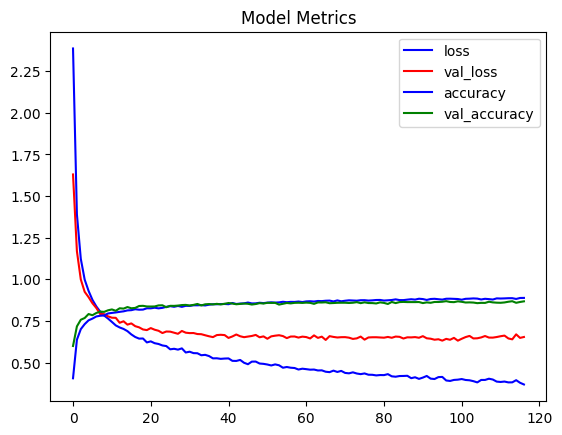

In [ ]:
import matplotlib.pyplot as plt
import os

metric_loss = history.history['loss']
metric_val_loss = history.history['val_loss']
metric_accuracy = history.history['accuracy']
metric_val_accuracy = history.history['val_accuracy']
.
epochs = range(len(metric_loss))

plt.plot(epochs, metric_loss, 'blue', label=metric_loss)
plt.plot(epochs, metric_val_loss, 'red', label=metric_val_loss)
plt.plot(epochs, metric_accuracy, 'blue', label=metric_accuracy)
plt.plot(epochs, metric_val_accuracy, 'green', label=metric_val_accuracy)

plt.title(str('Model Metrics'))
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])

plot_png = os.path.exists('metrics.png')
if plot_png:
    os.remove('metrics.png')
    plt.savefig('metrics.png', bbox_inches='tight')
else:
    plt.savefig('metrics.png', bbox_inches='tight')
print('[INFO] Successfully Saved metrics.png')

Saving the preprocessor

In [ ]:
from sklearn.pipeline import Pipeline

preprocessor = Pipeline([
    ('convertingArray', preprocess_first),
    ('Scaler', StandardScaler()),
    ('SelectingLandmarks', preprocess_second)
])

In [ ]:
preprocessor.fit(X_train_unprocessed)

Pipeline(steps=[('convertingArray',
                 FunctionTransformer(func=<function preprocess_first at 0x78fdc237cb80>)),
                ('Scaler', StandardScaler()),
                ('SelectingLandmarks',
                 FunctionTransformer(func=<function select_relevant_landmarks at 0x78fdc237de40>))])

In [ ]:
import cloudpickle

# Open the file in write binary ('wb') mode
with open('/content/drive/MyDrive/Colab Notebooks/Yoga-82/new_preprocessor.pkl', 'wb') as file:
    cloudpickle.dump(preprocessor, file)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Yoga-82/label_encoder.pkl', 'wb') as file:
    cloudpickle.dump(label_encoder, file)